In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as units
import numpy as np
import os
from bokeh.plotting import *
output_notebook()
%load_ext autoreload
%autoreload 2
from getGaiaData import GaiaClusterMembers
from astropy.modeling.models import KingProjectedAnalytic1D
from astropy.modeling import models, fitting
import scipy.optimize
import scipy.stats as stats

Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# read in my OC file and see if I can use that to define the input values
# https://github.com/ageller/compileOCs/blob/master/OCcompiled_clean.csv
#clusterName = 'NGC_188'
#clusterName ='NGC_2682'
#clusterName ='NGC_6819'
#clusterName ='M_35' #For second pass, use 3*rcore
#clusterName = 'NGC_6791'#skip second pass
#clusterName ='NGC_7789'

#clusterName = 'NGC_2516' 
#clusterName = 'NGC_3532' #Either a very big cluster or the cluster is very small and ontop of field stars
#clusterName = 'NGC_2506' 
#clusterName = 'M_37' 
#clusterName = 'NGC_6811' 
#clusterName = 'NGC_6866'

#clusterName = 'NGC_2264'

clusterName = 'M_21'

Radius= 0.08506632184403909
Reading data from file M_21_dir/M_21_GaiaData.ecsv ... 
Finding radial-velocity members ... 
Finding parallax members ... 
finding proper-motion members ...


/Users/annachilds/opt/anaconda3/envs/BASE9/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:756: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/annachilds/opt/anaconda3/envs/BASE9/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


combining memberships ...
Reading data from file M_21_dir/M_21_GaiaData.ecsv ... 


Finding radial-velocity members ... 
Finding parallax members ... 
finding proper-motion members ...
combining memberships ...
plotting CMD ...
generating phot file ...
generating yaml file ...
Final r_core= 0.04176821026746506
Saving data to file M_21_dir/M_21.csv ... 
done.


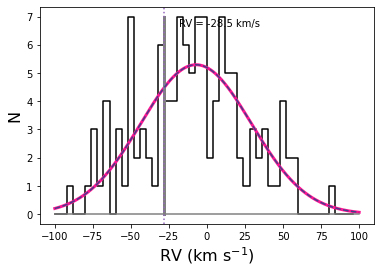

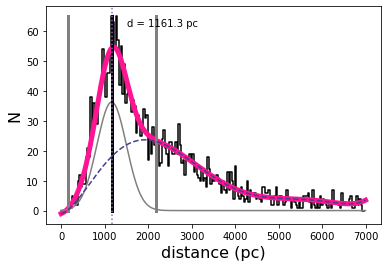

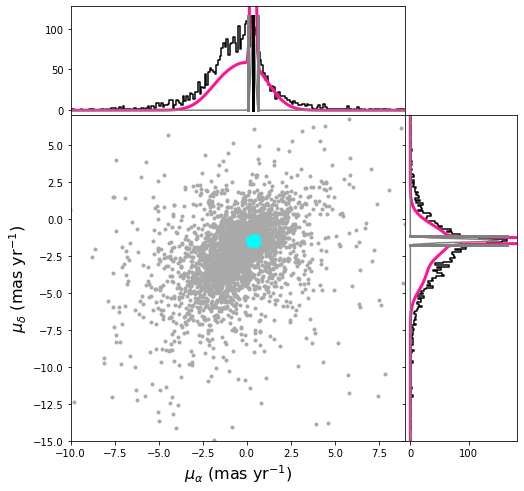

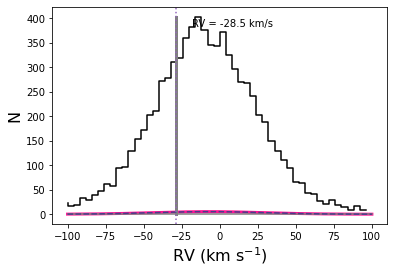

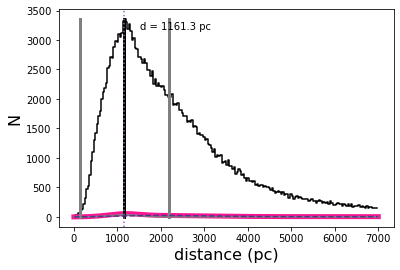

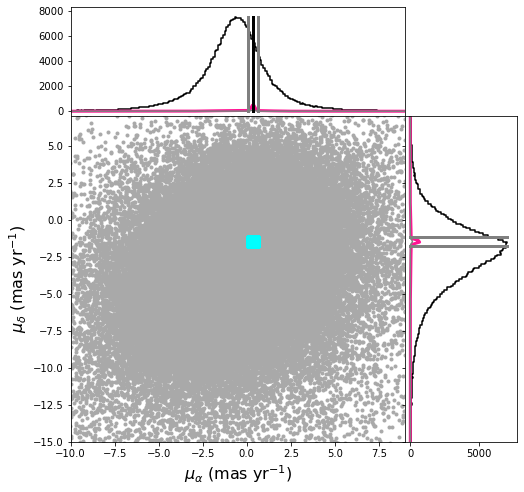

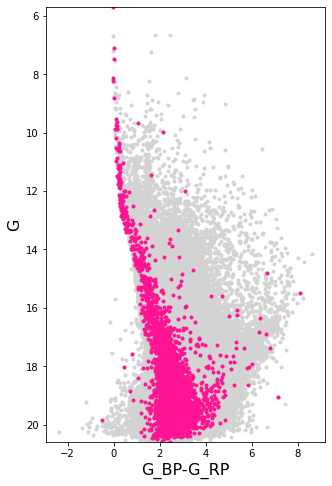

In [17]:
OCdf = pd.read_csv('OCcompiled_clean_v2.csv') #file with prior values for cluster centers from previous literature
row = OCdf.loc[OCdf['ID'] == clusterName].iloc[0]
dmod = 5.*np.log10(row['dist[pc]']) - 5.
err_dmod = (5.*1./np.log(10.)*(1./row['dist[pc]']))*row['err_dist[pc]'] # error propagation
cluster = GaiaClusterMembers()
pwd = clusterName+'_dir'
cluster.verbose = 1
try:
    os.makedirs(pwd+'/plots')
    os.makedirs(pwd)
except:
    next
cluster.photOutputFileName = pwd +'/'+clusterName + '.phot'
cluster.saveDataFile = pwd +'/'+clusterName + '.csv'
cluster.yamlOutputFileName = pwd + '/base9.yaml'
cluster.yamlTemplateFileName = 'template_base9.yaml'
cluster.yamlInputDict = {
    'photFile' : clusterName + '.phot',
    'outputFileBase' : pwd,
    'modelDirectory' : '/projects/p31721/BASE9/base-models/',
    'msRgbModel' : 5,
    'Fe_H' : [row['[Fe/H]'], row['[Fe/H]'], np.max([row['err_[Fe/H]'], 0.3])],
    'Av' : [row['Av[mag]'], row['Av[mag]'], np.max([row['err_Av[mag]'], 0.3])],
    'Y' : [0.29, 0.29, 0.0], # keep the defaults
    'carbonicity' : [0.38, 0.38, 0.0], # keep the defaults
    'logAge' : [np.log10(row['age[Myr]']*10**6), np.log10(row['age[Myr]']*10**6), np.inf],
    'distMod' : [dmod, dmod, np.max([err_dmod, 1.0])],
}
cluster.plotNameRoot = pwd+'/plots/'

cluster.sig_fac = 3 #default is to include stars within 3 sigma bounds around cluster fit mean. I used cluster.sig_fac=5 for NGC_2264.
#cluster.runAll(clusterName) #run this line to download Gaia data that will be saved to the file clusterName+'_dir/'+clusterName+'_GaiaData.ecsv'
cluster.runAll(clusterName,filename=clusterName+'_dir/'+clusterName+'_GaiaData.ecsv') #run this line if Gaia data has already been downloaded


In [ ]:
#'phot_g_mean_mag' ,'g_mean_psf_mag', 'j_m'

In [ ]:
#cluster.data['membership'][cluster.data['membership']>0.5]=0.5

In [ ]:
#max(cluster.data['membership'])

In [18]:
#interactive isochrone tool, may need to download additional dependencies to run?

layout = cluster.createInteractiveIsochrone('PARSEC.model', 
                                            initialGuess = [
                                                #cluster.yamlInputDict['logAge'][0], 
                                                #cluster.yamlInputDict['Fe_H'][0],
                                                6.98,
                                                0,
                                                cluster.yamlInputDict['distMod'][0],
                                                cluster.yamlInputDict['Av'][0]
                                            ],
                                   mag ='g_mean_psf_mag', color1 ='r_mean_psf_mag', color2 ='i_mean_psf_mag', xrng = [-4,4], yrng = [24,5])

# in order to run a Python callback in a Jupyter notbook, you need to include the following
def bkapp(doc):
    doc.add_root(layout)
    
show(bkapp)